# 5. Vanilla GAN on MNIST with FC layers

### Imports

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and dataloader

In [30]:
# Image transform to be applied to dataset
# - Tensor conversion
transform = transforms.Compose([transforms.ToTensor()])

In [31]:
# MNIST train dataset
mnist = torchvision.datasets.MNIST(root = './data/',
                                   train = True,
                                   transform = transform,
                                   download = True)

In [32]:
# Data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset = mnist,
                                          batch_size = batch_size, 
                                          shuffle = True)

### Discriminator model as a set of FC layers

In [33]:
# Discriminator
class Dicriminator(nn.Module):
    
    def __init__(self, hidden_size, image_size):
        # Init from nn.Module
        super().__init__()
        
        # FC layers
        self.D = nn.Sequential(nn.Linear(image_size, hidden_size),
                               nn.LeakyReLU(0.2),
                               nn.Linear(hidden_size, hidden_size),
                               nn.LeakyReLU(0.2),
                               nn.Linear(hidden_size, 1),
                               nn.Sigmoid())
        
    def forward(self, x):
        return self.D(x)

### Generator model as a set of FC layers

In [34]:
# Generator
class Generator(nn.Module):
    
    def __init__(self, latent_size, hidden_size, image_size):
        # Init from nn.Module
        super().__init__()
        
        # FC layers
        self.G = nn.Sequential(nn.Linear(latent_size, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, hidden_size),
                               nn.ReLU(),
                               nn.Linear(hidden_size, image_size),
                               nn.Tanh())
        
    def forward(self, x):
        return self.G(x)

### Trainer function

In [35]:
# Hyperparameters for model generation and training
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 300
batch_size = 32

In [36]:
# Create discriminator model
D = Dicriminator(hidden_size, image_size)
D.to(device)

Dicriminator(
  (D): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [37]:
# Create generator model
G = Generator(latent_size, hidden_size, image_size)
G.to(device)

Generator(
  (G): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [38]:
# Losses and optimizers
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [39]:
# History trackers for training curves
# Keeping track of losses and accuracy scores
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)
real_scores = np.zeros(num_epochs)
fake_scores = np.zeros(num_epochs)

**Note: running the cell below (our trainer function) will take a long time!**

In [43]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # 1. Flatten image
        images = images.view(batch_size, -1).cuda()
        images = Variable(images)
        
        # 2. Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).cuda()
        real_labels = Variable(real_labels)
        fake_labels = torch.zeros(batch_size, 1).cuda()
        fake_labels = Variable(fake_labels)
        
        """
        PART 1: TRAIN THE DISCRIMINATOR
        """

        # 3. Compute BCE_Loss using real images
        # Here, BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels = 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 3.bis. Compute BCELoss using fake images
        # Here, BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # First term of the loss is always zero since fake_labels = 0
        z = torch.randn(batch_size, latent_size).cuda()
        z = Variable(z)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 4. Backprop and optimize for D
        # Remember to reset gradients for both optimizers!
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        """
        PART 2: TRAIN THE GENERATOR
        """

        # 5. Generate fresh noise samples and produce fake images
        z = torch.randn(batch_size, latent_size).cuda()
        z = Variable(z)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # 6. We train G to maximize log(D(G(z))
        # instead of minimizing log(1-D(G(z)))
        # (Strictly equivalent but empirically better)
        g_loss = criterion(outputs, real_labels)
        
        # 7. Backprop and optimize G
        # Remember to reset gradients for both optimizers!
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        """
        PART 3: UPDATE STATISTICS FOR VISUALIZATION LATER
        """
        
        # 8. Update the losses and scores for mini-batches
        d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) \
            + d_loss.item()*(1./(i+1.))
        g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) \
            + g_loss.item()*(1./(i+1.))
        real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) \
            + real_score.mean().item()*(1./(i+1.))
        fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) \
            + fake_score.mean().item()*(1./(i+1.))
        
        # 9. Display
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))

Epoch [0/300], Step [200/1875], d_loss: 0.4322, g_loss: 6.4646, D(x): 0.80, D(G(z)): 0.11
Epoch [0/300], Step [400/1875], d_loss: 0.2549, g_loss: 5.0967, D(x): 0.87, D(G(z)): 0.09
Epoch [0/300], Step [600/1875], d_loss: 0.1202, g_loss: 4.7559, D(x): 0.94, D(G(z)): 0.06
Epoch [0/300], Step [800/1875], d_loss: 0.6969, g_loss: 1.7031, D(x): 0.81, D(G(z)): 0.34
Epoch [0/300], Step [1000/1875], d_loss: 0.0934, g_loss: 4.0231, D(x): 0.97, D(G(z)): 0.06
Epoch [0/300], Step [1200/1875], d_loss: 0.5148, g_loss: 2.5348, D(x): 0.81, D(G(z)): 0.22
Epoch [0/300], Step [1400/1875], d_loss: 0.6058, g_loss: 3.0714, D(x): 0.72, D(G(z)): 0.16
Epoch [0/300], Step [1600/1875], d_loss: 0.2764, g_loss: 2.9689, D(x): 0.91, D(G(z)): 0.16
Epoch [0/300], Step [1800/1875], d_loss: 0.1990, g_loss: 3.3967, D(x): 0.92, D(G(z)): 0.10
Epoch [1/300], Step [200/1875], d_loss: 0.2634, g_loss: 2.8863, D(x): 0.89, D(G(z)): 0.12
Epoch [1/300], Step [400/1875], d_loss: 0.3900, g_loss: 3.1367, D(x): 0.91, D(G(z)): 0.14
Epoch

Epoch [10/300], Step [400/1875], d_loss: 0.2154, g_loss: 4.9272, D(x): 1.00, D(G(z)): 0.16
Epoch [10/300], Step [600/1875], d_loss: 0.1497, g_loss: 5.4434, D(x): 0.94, D(G(z)): 0.04
Epoch [10/300], Step [800/1875], d_loss: 0.2950, g_loss: 5.1660, D(x): 0.92, D(G(z)): 0.04
Epoch [10/300], Step [1000/1875], d_loss: 0.2368, g_loss: 4.5379, D(x): 0.93, D(G(z)): 0.07
Epoch [10/300], Step [1200/1875], d_loss: 0.0339, g_loss: 5.9127, D(x): 0.99, D(G(z)): 0.03
Epoch [10/300], Step [1400/1875], d_loss: 0.1740, g_loss: 5.8126, D(x): 0.93, D(G(z)): 0.02
Epoch [10/300], Step [1600/1875], d_loss: 0.2045, g_loss: 7.0865, D(x): 0.96, D(G(z)): 0.03
Epoch [10/300], Step [1800/1875], d_loss: 0.0421, g_loss: 5.5408, D(x): 0.99, D(G(z)): 0.03
Epoch [11/300], Step [200/1875], d_loss: 0.0856, g_loss: 4.6075, D(x): 0.97, D(G(z)): 0.02
Epoch [11/300], Step [400/1875], d_loss: 0.1081, g_loss: 7.9973, D(x): 0.96, D(G(z)): 0.01
Epoch [11/300], Step [600/1875], d_loss: 0.0788, g_loss: 5.9760, D(x): 0.99, D(G(z)):

Epoch [20/300], Step [400/1875], d_loss: 0.1536, g_loss: 4.6600, D(x): 0.96, D(G(z)): 0.06
Epoch [20/300], Step [600/1875], d_loss: 0.1464, g_loss: 6.9332, D(x): 0.96, D(G(z)): 0.05
Epoch [20/300], Step [800/1875], d_loss: 0.1064, g_loss: 4.9519, D(x): 0.96, D(G(z)): 0.06
Epoch [20/300], Step [1000/1875], d_loss: 0.0733, g_loss: 4.4463, D(x): 0.98, D(G(z)): 0.05
Epoch [20/300], Step [1200/1875], d_loss: 0.2174, g_loss: 5.0204, D(x): 0.91, D(G(z)): 0.02
Epoch [20/300], Step [1400/1875], d_loss: 0.1280, g_loss: 6.4099, D(x): 0.97, D(G(z)): 0.06
Epoch [20/300], Step [1600/1875], d_loss: 0.2148, g_loss: 7.1703, D(x): 0.92, D(G(z)): 0.03
Epoch [20/300], Step [1800/1875], d_loss: 0.1977, g_loss: 5.3405, D(x): 0.96, D(G(z)): 0.06
Epoch [21/300], Step [200/1875], d_loss: 0.1148, g_loss: 5.0296, D(x): 0.94, D(G(z)): 0.03
Epoch [21/300], Step [400/1875], d_loss: 0.2261, g_loss: 5.1515, D(x): 0.96, D(G(z)): 0.08
Epoch [21/300], Step [600/1875], d_loss: 0.2678, g_loss: 5.3982, D(x): 0.97, D(G(z)):

Epoch [30/300], Step [400/1875], d_loss: 0.4393, g_loss: 3.6193, D(x): 0.93, D(G(z)): 0.18
Epoch [30/300], Step [600/1875], d_loss: 0.4889, g_loss: 4.2020, D(x): 0.81, D(G(z)): 0.06
Epoch [30/300], Step [800/1875], d_loss: 0.4446, g_loss: 4.2513, D(x): 0.89, D(G(z)): 0.12
Epoch [30/300], Step [1000/1875], d_loss: 0.5186, g_loss: 5.2985, D(x): 0.88, D(G(z)): 0.15
Epoch [30/300], Step [1200/1875], d_loss: 0.2361, g_loss: 3.4773, D(x): 0.91, D(G(z)): 0.10
Epoch [30/300], Step [1400/1875], d_loss: 0.2511, g_loss: 4.1178, D(x): 0.91, D(G(z)): 0.09
Epoch [30/300], Step [1600/1875], d_loss: 0.3271, g_loss: 3.3454, D(x): 0.93, D(G(z)): 0.16
Epoch [30/300], Step [1800/1875], d_loss: 0.2528, g_loss: 3.4138, D(x): 0.92, D(G(z)): 0.09
Epoch [31/300], Step [200/1875], d_loss: 0.3457, g_loss: 3.4277, D(x): 0.88, D(G(z)): 0.08
Epoch [31/300], Step [400/1875], d_loss: 0.3380, g_loss: 4.0411, D(x): 0.89, D(G(z)): 0.04
Epoch [31/300], Step [600/1875], d_loss: 0.1781, g_loss: 4.2891, D(x): 0.90, D(G(z)):

Epoch [40/300], Step [400/1875], d_loss: 0.3820, g_loss: 3.3932, D(x): 0.87, D(G(z)): 0.12
Epoch [40/300], Step [600/1875], d_loss: 0.5037, g_loss: 4.7519, D(x): 0.76, D(G(z)): 0.05
Epoch [40/300], Step [800/1875], d_loss: 0.3859, g_loss: 4.4278, D(x): 0.86, D(G(z)): 0.10
Epoch [40/300], Step [1000/1875], d_loss: 0.2621, g_loss: 4.7409, D(x): 0.91, D(G(z)): 0.10
Epoch [40/300], Step [1200/1875], d_loss: 0.4035, g_loss: 3.0988, D(x): 0.94, D(G(z)): 0.18
Epoch [40/300], Step [1400/1875], d_loss: 0.3883, g_loss: 4.1782, D(x): 0.88, D(G(z)): 0.12
Epoch [40/300], Step [1600/1875], d_loss: 0.2599, g_loss: 2.7449, D(x): 0.92, D(G(z)): 0.13
Epoch [40/300], Step [1800/1875], d_loss: 0.3881, g_loss: 3.7825, D(x): 0.88, D(G(z)): 0.17
Epoch [41/300], Step [200/1875], d_loss: 0.3041, g_loss: 3.6032, D(x): 0.85, D(G(z)): 0.06
Epoch [41/300], Step [400/1875], d_loss: 0.2350, g_loss: 3.5400, D(x): 0.94, D(G(z)): 0.11
Epoch [41/300], Step [600/1875], d_loss: 0.3627, g_loss: 4.0168, D(x): 0.85, D(G(z)):

Epoch [50/300], Step [400/1875], d_loss: 0.3132, g_loss: 2.9436, D(x): 0.97, D(G(z)): 0.19
Epoch [50/300], Step [600/1875], d_loss: 0.3955, g_loss: 3.5508, D(x): 0.88, D(G(z)): 0.14
Epoch [50/300], Step [800/1875], d_loss: 0.4088, g_loss: 4.0655, D(x): 0.84, D(G(z)): 0.04
Epoch [50/300], Step [1000/1875], d_loss: 0.8346, g_loss: 3.6406, D(x): 0.72, D(G(z)): 0.14
Epoch [50/300], Step [1200/1875], d_loss: 0.5112, g_loss: 3.3076, D(x): 0.94, D(G(z)): 0.22
Epoch [50/300], Step [1400/1875], d_loss: 0.4031, g_loss: 2.9572, D(x): 0.86, D(G(z)): 0.11
Epoch [50/300], Step [1600/1875], d_loss: 0.4421, g_loss: 2.9854, D(x): 0.91, D(G(z)): 0.22
Epoch [50/300], Step [1800/1875], d_loss: 0.4390, g_loss: 4.1300, D(x): 0.81, D(G(z)): 0.10
Epoch [51/300], Step [200/1875], d_loss: 0.5846, g_loss: 3.7180, D(x): 0.82, D(G(z)): 0.14
Epoch [51/300], Step [400/1875], d_loss: 0.3980, g_loss: 3.0297, D(x): 0.93, D(G(z)): 0.18
Epoch [51/300], Step [600/1875], d_loss: 0.3637, g_loss: 3.2520, D(x): 0.84, D(G(z)):

Epoch [60/300], Step [400/1875], d_loss: 0.3141, g_loss: 3.4184, D(x): 0.85, D(G(z)): 0.08
Epoch [60/300], Step [600/1875], d_loss: 0.3826, g_loss: 2.8770, D(x): 0.85, D(G(z)): 0.12
Epoch [60/300], Step [800/1875], d_loss: 0.7405, g_loss: 2.8943, D(x): 0.86, D(G(z)): 0.27
Epoch [60/300], Step [1000/1875], d_loss: 0.7819, g_loss: 3.4463, D(x): 0.74, D(G(z)): 0.16
Epoch [60/300], Step [1200/1875], d_loss: 0.4398, g_loss: 3.0930, D(x): 0.87, D(G(z)): 0.13
Epoch [60/300], Step [1400/1875], d_loss: 0.4812, g_loss: 2.1122, D(x): 0.92, D(G(z)): 0.25
Epoch [60/300], Step [1600/1875], d_loss: 0.3593, g_loss: 2.9768, D(x): 0.95, D(G(z)): 0.20
Epoch [60/300], Step [1800/1875], d_loss: 0.5133, g_loss: 3.1018, D(x): 0.87, D(G(z)): 0.18
Epoch [61/300], Step [200/1875], d_loss: 0.3720, g_loss: 3.3263, D(x): 0.90, D(G(z)): 0.16
Epoch [61/300], Step [400/1875], d_loss: 0.5471, g_loss: 2.3929, D(x): 0.86, D(G(z)): 0.20
Epoch [61/300], Step [600/1875], d_loss: 0.6333, g_loss: 2.8338, D(x): 0.85, D(G(z)):

Epoch [70/300], Step [400/1875], d_loss: 0.5199, g_loss: 3.2391, D(x): 0.77, D(G(z)): 0.12
Epoch [70/300], Step [600/1875], d_loss: 0.3336, g_loss: 3.2845, D(x): 0.86, D(G(z)): 0.12
Epoch [70/300], Step [800/1875], d_loss: 0.7326, g_loss: 3.1993, D(x): 0.84, D(G(z)): 0.27
Epoch [70/300], Step [1000/1875], d_loss: 0.3336, g_loss: 3.4187, D(x): 0.89, D(G(z)): 0.13
Epoch [70/300], Step [1200/1875], d_loss: 0.3601, g_loss: 3.0173, D(x): 0.87, D(G(z)): 0.11
Epoch [70/300], Step [1400/1875], d_loss: 0.5504, g_loss: 4.1230, D(x): 0.85, D(G(z)): 0.20
Epoch [70/300], Step [1600/1875], d_loss: 0.7363, g_loss: 3.1300, D(x): 0.79, D(G(z)): 0.21
Epoch [70/300], Step [1800/1875], d_loss: 0.6249, g_loss: 2.8181, D(x): 0.78, D(G(z)): 0.14
Epoch [71/300], Step [200/1875], d_loss: 0.4607, g_loss: 2.4993, D(x): 0.85, D(G(z)): 0.13
Epoch [71/300], Step [400/1875], d_loss: 0.5996, g_loss: 2.2844, D(x): 0.87, D(G(z)): 0.19
Epoch [71/300], Step [600/1875], d_loss: 0.4824, g_loss: 2.7735, D(x): 0.79, D(G(z)):

Epoch [80/300], Step [400/1875], d_loss: 0.4433, g_loss: 3.2694, D(x): 0.89, D(G(z)): 0.18
Epoch [80/300], Step [600/1875], d_loss: 0.4232, g_loss: 2.6970, D(x): 0.86, D(G(z)): 0.17
Epoch [80/300], Step [800/1875], d_loss: 0.5106, g_loss: 3.1031, D(x): 0.85, D(G(z)): 0.20
Epoch [80/300], Step [1000/1875], d_loss: 0.9869, g_loss: 3.5286, D(x): 0.68, D(G(z)): 0.17
Epoch [80/300], Step [1200/1875], d_loss: 0.9340, g_loss: 3.5871, D(x): 0.72, D(G(z)): 0.22
Epoch [80/300], Step [1400/1875], d_loss: 0.5569, g_loss: 2.8675, D(x): 0.78, D(G(z)): 0.08
Epoch [80/300], Step [1600/1875], d_loss: 0.6016, g_loss: 3.3167, D(x): 0.83, D(G(z)): 0.23
Epoch [80/300], Step [1800/1875], d_loss: 0.3919, g_loss: 3.7443, D(x): 0.89, D(G(z)): 0.17
Epoch [81/300], Step [200/1875], d_loss: 0.4339, g_loss: 2.8578, D(x): 0.87, D(G(z)): 0.17
Epoch [81/300], Step [400/1875], d_loss: 0.3519, g_loss: 3.2790, D(x): 0.89, D(G(z)): 0.16
Epoch [81/300], Step [600/1875], d_loss: 0.5168, g_loss: 3.6515, D(x): 0.88, D(G(z)):

Epoch [90/300], Step [400/1875], d_loss: 0.2946, g_loss: 2.7039, D(x): 0.94, D(G(z)): 0.15
Epoch [90/300], Step [600/1875], d_loss: 0.3424, g_loss: 2.6705, D(x): 0.91, D(G(z)): 0.18
Epoch [90/300], Step [800/1875], d_loss: 0.6731, g_loss: 2.7811, D(x): 0.86, D(G(z)): 0.24
Epoch [90/300], Step [1000/1875], d_loss: 0.7511, g_loss: 2.9926, D(x): 0.76, D(G(z)): 0.15
Epoch [90/300], Step [1200/1875], d_loss: 0.5123, g_loss: 3.3630, D(x): 0.86, D(G(z)): 0.19
Epoch [90/300], Step [1400/1875], d_loss: 0.5867, g_loss: 3.6060, D(x): 0.77, D(G(z)): 0.12
Epoch [90/300], Step [1600/1875], d_loss: 0.4470, g_loss: 3.7690, D(x): 0.86, D(G(z)): 0.15
Epoch [90/300], Step [1800/1875], d_loss: 0.5283, g_loss: 3.9234, D(x): 0.75, D(G(z)): 0.09
Epoch [91/300], Step [200/1875], d_loss: 0.5147, g_loss: 3.2203, D(x): 0.82, D(G(z)): 0.14
Epoch [91/300], Step [400/1875], d_loss: 0.4662, g_loss: 3.0047, D(x): 0.78, D(G(z)): 0.09
Epoch [91/300], Step [600/1875], d_loss: 0.3979, g_loss: 2.7847, D(x): 0.94, D(G(z)):

Epoch [100/300], Step [400/1875], d_loss: 0.5873, g_loss: 3.1077, D(x): 0.81, D(G(z)): 0.19
Epoch [100/300], Step [600/1875], d_loss: 0.4739, g_loss: 1.9373, D(x): 0.82, D(G(z)): 0.12
Epoch [100/300], Step [800/1875], d_loss: 0.8831, g_loss: 2.7333, D(x): 0.80, D(G(z)): 0.33
Epoch [100/300], Step [1000/1875], d_loss: 0.4783, g_loss: 2.3381, D(x): 0.88, D(G(z)): 0.16
Epoch [100/300], Step [1200/1875], d_loss: 0.5967, g_loss: 2.7773, D(x): 0.83, D(G(z)): 0.20
Epoch [100/300], Step [1400/1875], d_loss: 0.4242, g_loss: 3.5291, D(x): 0.85, D(G(z)): 0.14
Epoch [100/300], Step [1600/1875], d_loss: 0.3773, g_loss: 2.7121, D(x): 0.88, D(G(z)): 0.13
Epoch [100/300], Step [1800/1875], d_loss: 0.6606, g_loss: 3.4913, D(x): 0.81, D(G(z)): 0.19
Epoch [101/300], Step [200/1875], d_loss: 0.4563, g_loss: 3.1943, D(x): 0.87, D(G(z)): 0.15
Epoch [101/300], Step [400/1875], d_loss: 0.6293, g_loss: 3.0832, D(x): 0.90, D(G(z)): 0.28
Epoch [101/300], Step [600/1875], d_loss: 0.5935, g_loss: 3.4713, D(x): 0.8

Epoch [110/300], Step [200/1875], d_loss: 0.3417, g_loss: 3.7749, D(x): 0.89, D(G(z)): 0.10
Epoch [110/300], Step [400/1875], d_loss: 0.2627, g_loss: 2.2084, D(x): 0.90, D(G(z)): 0.12
Epoch [110/300], Step [600/1875], d_loss: 0.4477, g_loss: 2.9804, D(x): 0.78, D(G(z)): 0.10
Epoch [110/300], Step [800/1875], d_loss: 0.5408, g_loss: 3.1114, D(x): 0.80, D(G(z)): 0.13
Epoch [110/300], Step [1000/1875], d_loss: 0.5992, g_loss: 2.7058, D(x): 0.84, D(G(z)): 0.20
Epoch [110/300], Step [1200/1875], d_loss: 0.4912, g_loss: 3.3379, D(x): 0.85, D(G(z)): 0.16
Epoch [110/300], Step [1400/1875], d_loss: 0.3728, g_loss: 3.1174, D(x): 0.88, D(G(z)): 0.13
Epoch [110/300], Step [1600/1875], d_loss: 0.5360, g_loss: 2.7099, D(x): 0.87, D(G(z)): 0.22
Epoch [110/300], Step [1800/1875], d_loss: 0.5882, g_loss: 2.8372, D(x): 0.94, D(G(z)): 0.28
Epoch [111/300], Step [200/1875], d_loss: 0.4564, g_loss: 2.9258, D(x): 0.79, D(G(z)): 0.09
Epoch [111/300], Step [400/1875], d_loss: 0.5317, g_loss: 3.0316, D(x): 0.8

Epoch [119/300], Step [1800/1875], d_loss: 0.4156, g_loss: 3.1317, D(x): 0.89, D(G(z)): 0.18
Epoch [120/300], Step [200/1875], d_loss: 0.5472, g_loss: 2.9607, D(x): 0.83, D(G(z)): 0.17
Epoch [120/300], Step [400/1875], d_loss: 0.4864, g_loss: 2.2667, D(x): 0.89, D(G(z)): 0.21
Epoch [120/300], Step [600/1875], d_loss: 0.5832, g_loss: 2.9466, D(x): 0.74, D(G(z)): 0.12
Epoch [120/300], Step [800/1875], d_loss: 0.4273, g_loss: 2.6422, D(x): 0.85, D(G(z)): 0.15
Epoch [120/300], Step [1000/1875], d_loss: 0.5590, g_loss: 3.0929, D(x): 0.91, D(G(z)): 0.25
Epoch [120/300], Step [1200/1875], d_loss: 0.6678, g_loss: 3.1804, D(x): 0.79, D(G(z)): 0.21
Epoch [120/300], Step [1400/1875], d_loss: 0.3450, g_loss: 3.8145, D(x): 0.88, D(G(z)): 0.14
Epoch [120/300], Step [1600/1875], d_loss: 0.4156, g_loss: 3.0137, D(x): 0.89, D(G(z)): 0.15
Epoch [120/300], Step [1800/1875], d_loss: 0.5047, g_loss: 3.1776, D(x): 0.82, D(G(z)): 0.16
Epoch [121/300], Step [200/1875], d_loss: 0.3900, g_loss: 3.3313, D(x): 0.

Epoch [129/300], Step [1600/1875], d_loss: 0.8861, g_loss: 3.2485, D(x): 0.80, D(G(z)): 0.17
Epoch [129/300], Step [1800/1875], d_loss: 0.4276, g_loss: 3.5736, D(x): 0.83, D(G(z)): 0.11
Epoch [130/300], Step [200/1875], d_loss: 0.3054, g_loss: 3.0144, D(x): 0.90, D(G(z)): 0.15
Epoch [130/300], Step [400/1875], d_loss: 0.3604, g_loss: 2.7462, D(x): 0.89, D(G(z)): 0.12
Epoch [130/300], Step [600/1875], d_loss: 0.4258, g_loss: 2.2544, D(x): 0.86, D(G(z)): 0.18
Epoch [130/300], Step [800/1875], d_loss: 0.3758, g_loss: 2.3635, D(x): 0.89, D(G(z)): 0.18
Epoch [130/300], Step [1000/1875], d_loss: 0.7434, g_loss: 3.4243, D(x): 0.82, D(G(z)): 0.25
Epoch [130/300], Step [1200/1875], d_loss: 0.6602, g_loss: 3.7783, D(x): 0.70, D(G(z)): 0.09
Epoch [130/300], Step [1400/1875], d_loss: 0.7294, g_loss: 1.8277, D(x): 0.84, D(G(z)): 0.27
Epoch [130/300], Step [1600/1875], d_loss: 0.6533, g_loss: 3.5619, D(x): 0.74, D(G(z)): 0.14
Epoch [130/300], Step [1800/1875], d_loss: 0.3628, g_loss: 2.7313, D(x): 0

Epoch [139/300], Step [1400/1875], d_loss: 0.4075, g_loss: 3.5166, D(x): 0.84, D(G(z)): 0.14
Epoch [139/300], Step [1600/1875], d_loss: 0.7132, g_loss: 3.5721, D(x): 0.78, D(G(z)): 0.17
Epoch [139/300], Step [1800/1875], d_loss: 0.6656, g_loss: 2.7647, D(x): 0.76, D(G(z)): 0.14
Epoch [140/300], Step [200/1875], d_loss: 0.5551, g_loss: 3.0430, D(x): 0.74, D(G(z)): 0.09
Epoch [140/300], Step [400/1875], d_loss: 0.4435, g_loss: 2.9168, D(x): 0.81, D(G(z)): 0.08
Epoch [140/300], Step [600/1875], d_loss: 0.6467, g_loss: 2.9436, D(x): 0.75, D(G(z)): 0.14
Epoch [140/300], Step [800/1875], d_loss: 0.5751, g_loss: 2.8143, D(x): 0.78, D(G(z)): 0.09
Epoch [140/300], Step [1000/1875], d_loss: 0.6115, g_loss: 2.9141, D(x): 0.78, D(G(z)): 0.20
Epoch [140/300], Step [1200/1875], d_loss: 0.5246, g_loss: 2.5350, D(x): 0.87, D(G(z)): 0.18
Epoch [140/300], Step [1400/1875], d_loss: 0.7594, g_loss: 2.1667, D(x): 0.82, D(G(z)): 0.26
Epoch [140/300], Step [1600/1875], d_loss: 0.4172, g_loss: 3.3470, D(x): 0

Epoch [149/300], Step [1200/1875], d_loss: 0.6553, g_loss: 3.1066, D(x): 0.81, D(G(z)): 0.18
Epoch [149/300], Step [1400/1875], d_loss: 0.5382, g_loss: 3.5248, D(x): 0.85, D(G(z)): 0.20
Epoch [149/300], Step [1600/1875], d_loss: 0.4387, g_loss: 2.8179, D(x): 0.85, D(G(z)): 0.19
Epoch [149/300], Step [1800/1875], d_loss: 0.4778, g_loss: 3.2550, D(x): 0.79, D(G(z)): 0.09
Epoch [150/300], Step [200/1875], d_loss: 0.2893, g_loss: 3.7090, D(x): 0.88, D(G(z)): 0.09
Epoch [150/300], Step [400/1875], d_loss: 0.7773, g_loss: 3.2670, D(x): 0.73, D(G(z)): 0.16
Epoch [150/300], Step [600/1875], d_loss: 0.5999, g_loss: 2.4816, D(x): 0.84, D(G(z)): 0.20
Epoch [150/300], Step [800/1875], d_loss: 0.7580, g_loss: 2.2793, D(x): 0.72, D(G(z)): 0.14
Epoch [150/300], Step [1000/1875], d_loss: 0.6233, g_loss: 2.8371, D(x): 0.75, D(G(z)): 0.12
Epoch [150/300], Step [1200/1875], d_loss: 0.6167, g_loss: 2.6423, D(x): 0.83, D(G(z)): 0.22
Epoch [150/300], Step [1400/1875], d_loss: 0.4467, g_loss: 3.1590, D(x): 0

Epoch [159/300], Step [1000/1875], d_loss: 0.7808, g_loss: 2.0821, D(x): 0.74, D(G(z)): 0.21
Epoch [159/300], Step [1200/1875], d_loss: 0.5554, g_loss: 2.4760, D(x): 0.84, D(G(z)): 0.17
Epoch [159/300], Step [1400/1875], d_loss: 0.6716, g_loss: 2.6191, D(x): 0.86, D(G(z)): 0.29
Epoch [159/300], Step [1600/1875], d_loss: 0.5272, g_loss: 2.4297, D(x): 0.86, D(G(z)): 0.17
Epoch [159/300], Step [1800/1875], d_loss: 0.5768, g_loss: 3.0152, D(x): 0.89, D(G(z)): 0.23
Epoch [160/300], Step [200/1875], d_loss: 0.5876, g_loss: 2.3823, D(x): 0.85, D(G(z)): 0.16
Epoch [160/300], Step [400/1875], d_loss: 0.8290, g_loss: 3.1000, D(x): 0.84, D(G(z)): 0.29
Epoch [160/300], Step [600/1875], d_loss: 0.6831, g_loss: 2.2029, D(x): 0.88, D(G(z)): 0.29
Epoch [160/300], Step [800/1875], d_loss: 0.6797, g_loss: 3.2777, D(x): 0.81, D(G(z)): 0.19
Epoch [160/300], Step [1000/1875], d_loss: 0.7148, g_loss: 3.1333, D(x): 0.72, D(G(z)): 0.17
Epoch [160/300], Step [1200/1875], d_loss: 0.5426, g_loss: 3.4102, D(x): 0

Epoch [169/300], Step [800/1875], d_loss: 0.5698, g_loss: 2.9665, D(x): 0.81, D(G(z)): 0.16
Epoch [169/300], Step [1000/1875], d_loss: 0.5946, g_loss: 2.7148, D(x): 0.81, D(G(z)): 0.18
Epoch [169/300], Step [1200/1875], d_loss: 0.6313, g_loss: 2.4290, D(x): 0.87, D(G(z)): 0.23
Epoch [169/300], Step [1400/1875], d_loss: 0.4904, g_loss: 2.8297, D(x): 0.83, D(G(z)): 0.13
Epoch [169/300], Step [1600/1875], d_loss: 0.7218, g_loss: 3.0156, D(x): 0.75, D(G(z)): 0.16
Epoch [169/300], Step [1800/1875], d_loss: 0.3652, g_loss: 2.5697, D(x): 0.88, D(G(z)): 0.16
Epoch [170/300], Step [200/1875], d_loss: 0.3822, g_loss: 2.6108, D(x): 0.87, D(G(z)): 0.14
Epoch [170/300], Step [400/1875], d_loss: 0.6912, g_loss: 2.3186, D(x): 0.71, D(G(z)): 0.15
Epoch [170/300], Step [600/1875], d_loss: 0.5948, g_loss: 2.7181, D(x): 0.85, D(G(z)): 0.27
Epoch [170/300], Step [800/1875], d_loss: 0.5553, g_loss: 2.4123, D(x): 0.87, D(G(z)): 0.20
Epoch [170/300], Step [1000/1875], d_loss: 0.6694, g_loss: 1.7876, D(x): 0.

Epoch [179/300], Step [600/1875], d_loss: 0.6033, g_loss: 4.0697, D(x): 0.76, D(G(z)): 0.13
Epoch [179/300], Step [800/1875], d_loss: 0.5502, g_loss: 2.5344, D(x): 0.92, D(G(z)): 0.28
Epoch [179/300], Step [1000/1875], d_loss: 0.6670, g_loss: 3.3823, D(x): 0.83, D(G(z)): 0.26
Epoch [179/300], Step [1200/1875], d_loss: 0.7452, g_loss: 3.8226, D(x): 0.74, D(G(z)): 0.19
Epoch [179/300], Step [1400/1875], d_loss: 0.6831, g_loss: 2.7415, D(x): 0.84, D(G(z)): 0.26
Epoch [179/300], Step [1600/1875], d_loss: 0.4474, g_loss: 2.5466, D(x): 0.82, D(G(z)): 0.11
Epoch [179/300], Step [1800/1875], d_loss: 0.4954, g_loss: 2.6589, D(x): 0.93, D(G(z)): 0.22
Epoch [180/300], Step [200/1875], d_loss: 0.4985, g_loss: 3.6252, D(x): 0.84, D(G(z)): 0.16
Epoch [180/300], Step [400/1875], d_loss: 0.5717, g_loss: 3.1548, D(x): 0.77, D(G(z)): 0.11
Epoch [180/300], Step [600/1875], d_loss: 0.3623, g_loss: 3.1573, D(x): 0.87, D(G(z)): 0.13
Epoch [180/300], Step [800/1875], d_loss: 0.4910, g_loss: 2.5568, D(x): 0.8

Epoch [189/300], Step [400/1875], d_loss: 0.4840, g_loss: 2.3979, D(x): 0.92, D(G(z)): 0.26
Epoch [189/300], Step [600/1875], d_loss: 0.5364, g_loss: 2.1321, D(x): 0.85, D(G(z)): 0.19
Epoch [189/300], Step [800/1875], d_loss: 0.9530, g_loss: 2.4909, D(x): 0.81, D(G(z)): 0.21
Epoch [189/300], Step [1000/1875], d_loss: 0.5860, g_loss: 2.5822, D(x): 0.77, D(G(z)): 0.10
Epoch [189/300], Step [1200/1875], d_loss: 0.8232, g_loss: 3.4100, D(x): 0.78, D(G(z)): 0.19
Epoch [189/300], Step [1400/1875], d_loss: 0.3153, g_loss: 3.3283, D(x): 0.92, D(G(z)): 0.16
Epoch [189/300], Step [1600/1875], d_loss: 0.8311, g_loss: 3.0707, D(x): 0.69, D(G(z)): 0.12
Epoch [189/300], Step [1800/1875], d_loss: 0.3396, g_loss: 2.0453, D(x): 0.91, D(G(z)): 0.16
Epoch [190/300], Step [200/1875], d_loss: 0.8612, g_loss: 2.0761, D(x): 0.76, D(G(z)): 0.29
Epoch [190/300], Step [400/1875], d_loss: 0.3555, g_loss: 2.9479, D(x): 0.90, D(G(z)): 0.16
Epoch [190/300], Step [600/1875], d_loss: 0.6856, g_loss: 2.3300, D(x): 0.8

Epoch [199/300], Step [200/1875], d_loss: 0.3951, g_loss: 2.7046, D(x): 0.92, D(G(z)): 0.21
Epoch [199/300], Step [400/1875], d_loss: 0.4295, g_loss: 2.6266, D(x): 0.83, D(G(z)): 0.15
Epoch [199/300], Step [600/1875], d_loss: 0.7185, g_loss: 2.4605, D(x): 0.73, D(G(z)): 0.18
Epoch [199/300], Step [800/1875], d_loss: 0.7243, g_loss: 2.5052, D(x): 0.81, D(G(z)): 0.24
Epoch [199/300], Step [1000/1875], d_loss: 0.6762, g_loss: 3.4052, D(x): 0.77, D(G(z)): 0.15
Epoch [199/300], Step [1200/1875], d_loss: 0.5594, g_loss: 2.3801, D(x): 0.82, D(G(z)): 0.21
Epoch [199/300], Step [1400/1875], d_loss: 0.5376, g_loss: 3.2356, D(x): 0.80, D(G(z)): 0.11
Epoch [199/300], Step [1600/1875], d_loss: 0.5559, g_loss: 2.4033, D(x): 0.81, D(G(z)): 0.19
Epoch [199/300], Step [1800/1875], d_loss: 0.6117, g_loss: 2.8000, D(x): 0.84, D(G(z)): 0.21
Epoch [200/300], Step [200/1875], d_loss: 0.6412, g_loss: 2.2968, D(x): 0.88, D(G(z)): 0.23
Epoch [200/300], Step [400/1875], d_loss: 0.3861, g_loss: 2.5678, D(x): 0.9

Epoch [208/300], Step [1800/1875], d_loss: 0.4786, g_loss: 2.9666, D(x): 0.86, D(G(z)): 0.19
Epoch [209/300], Step [200/1875], d_loss: 0.5226, g_loss: 3.0375, D(x): 0.77, D(G(z)): 0.12
Epoch [209/300], Step [400/1875], d_loss: 0.6359, g_loss: 3.1270, D(x): 0.82, D(G(z)): 0.19
Epoch [209/300], Step [600/1875], d_loss: 1.0651, g_loss: 2.4902, D(x): 0.72, D(G(z)): 0.20
Epoch [209/300], Step [800/1875], d_loss: 0.4901, g_loss: 3.2064, D(x): 0.81, D(G(z)): 0.12
Epoch [209/300], Step [1000/1875], d_loss: 0.4814, g_loss: 2.1053, D(x): 0.93, D(G(z)): 0.26
Epoch [209/300], Step [1200/1875], d_loss: 0.5014, g_loss: 2.3384, D(x): 0.89, D(G(z)): 0.24
Epoch [209/300], Step [1400/1875], d_loss: 0.4953, g_loss: 2.4395, D(x): 0.78, D(G(z)): 0.12
Epoch [209/300], Step [1600/1875], d_loss: 0.6864, g_loss: 2.6112, D(x): 0.87, D(G(z)): 0.25
Epoch [209/300], Step [1800/1875], d_loss: 0.5127, g_loss: 2.4072, D(x): 0.87, D(G(z)): 0.22
Epoch [210/300], Step [200/1875], d_loss: 0.2608, g_loss: 2.9367, D(x): 0.

Epoch [218/300], Step [1600/1875], d_loss: 0.4284, g_loss: 2.9344, D(x): 0.80, D(G(z)): 0.12
Epoch [218/300], Step [1800/1875], d_loss: 0.5162, g_loss: 2.1158, D(x): 0.91, D(G(z)): 0.27
Epoch [219/300], Step [200/1875], d_loss: 0.6823, g_loss: 2.5213, D(x): 0.82, D(G(z)): 0.19
Epoch [219/300], Step [400/1875], d_loss: 0.4770, g_loss: 3.3281, D(x): 0.90, D(G(z)): 0.16
Epoch [219/300], Step [600/1875], d_loss: 0.8335, g_loss: 2.7250, D(x): 0.84, D(G(z)): 0.30
Epoch [219/300], Step [800/1875], d_loss: 0.5425, g_loss: 2.4451, D(x): 0.83, D(G(z)): 0.17
Epoch [219/300], Step [1000/1875], d_loss: 0.5442, g_loss: 2.0424, D(x): 0.84, D(G(z)): 0.17
Epoch [219/300], Step [1200/1875], d_loss: 0.9016, g_loss: 2.3458, D(x): 0.77, D(G(z)): 0.26
Epoch [219/300], Step [1400/1875], d_loss: 0.6854, g_loss: 2.6814, D(x): 0.76, D(G(z)): 0.15
Epoch [219/300], Step [1600/1875], d_loss: 0.6504, g_loss: 2.8850, D(x): 0.80, D(G(z)): 0.20
Epoch [219/300], Step [1800/1875], d_loss: 0.3211, g_loss: 2.6852, D(x): 0

Epoch [228/300], Step [1400/1875], d_loss: 0.3999, g_loss: 3.2067, D(x): 0.80, D(G(z)): 0.10
Epoch [228/300], Step [1600/1875], d_loss: 0.5219, g_loss: 2.7734, D(x): 0.87, D(G(z)): 0.20
Epoch [228/300], Step [1800/1875], d_loss: 0.8549, g_loss: 2.2801, D(x): 0.74, D(G(z)): 0.24
Epoch [229/300], Step [200/1875], d_loss: 0.6824, g_loss: 2.6156, D(x): 0.93, D(G(z)): 0.33
Epoch [229/300], Step [400/1875], d_loss: 0.4262, g_loss: 3.0717, D(x): 0.85, D(G(z)): 0.17
Epoch [229/300], Step [600/1875], d_loss: 0.4694, g_loss: 3.1676, D(x): 0.83, D(G(z)): 0.16
Epoch [229/300], Step [800/1875], d_loss: 1.0294, g_loss: 2.2542, D(x): 0.81, D(G(z)): 0.36
Epoch [229/300], Step [1000/1875], d_loss: 0.5012, g_loss: 2.7738, D(x): 0.81, D(G(z)): 0.16
Epoch [229/300], Step [1200/1875], d_loss: 0.5830, g_loss: 2.6075, D(x): 0.84, D(G(z)): 0.21
Epoch [229/300], Step [1400/1875], d_loss: 0.5066, g_loss: 2.3694, D(x): 0.78, D(G(z)): 0.13
Epoch [229/300], Step [1600/1875], d_loss: 0.7581, g_loss: 2.0568, D(x): 0

Epoch [238/300], Step [1200/1875], d_loss: 0.8024, g_loss: 2.0120, D(x): 0.80, D(G(z)): 0.25
Epoch [238/300], Step [1400/1875], d_loss: 0.8631, g_loss: 2.6819, D(x): 0.70, D(G(z)): 0.19
Epoch [238/300], Step [1600/1875], d_loss: 0.8359, g_loss: 2.2361, D(x): 0.77, D(G(z)): 0.24
Epoch [238/300], Step [1800/1875], d_loss: 0.4394, g_loss: 3.4334, D(x): 0.91, D(G(z)): 0.22
Epoch [239/300], Step [200/1875], d_loss: 0.5954, g_loss: 1.9855, D(x): 0.85, D(G(z)): 0.24
Epoch [239/300], Step [400/1875], d_loss: 0.4672, g_loss: 3.0048, D(x): 0.83, D(G(z)): 0.12
Epoch [239/300], Step [600/1875], d_loss: 0.4039, g_loss: 2.6333, D(x): 0.85, D(G(z)): 0.13
Epoch [239/300], Step [800/1875], d_loss: 0.2607, g_loss: 3.1227, D(x): 0.89, D(G(z)): 0.09
Epoch [239/300], Step [1000/1875], d_loss: 0.3458, g_loss: 2.7239, D(x): 0.90, D(G(z)): 0.16
Epoch [239/300], Step [1200/1875], d_loss: 0.5679, g_loss: 1.7660, D(x): 0.88, D(G(z)): 0.26
Epoch [239/300], Step [1400/1875], d_loss: 0.7223, g_loss: 1.8408, D(x): 0

Epoch [248/300], Step [1000/1875], d_loss: 0.5955, g_loss: 2.4923, D(x): 0.77, D(G(z)): 0.13
Epoch [248/300], Step [1200/1875], d_loss: 0.7336, g_loss: 2.7979, D(x): 0.84, D(G(z)): 0.21
Epoch [248/300], Step [1400/1875], d_loss: 0.7868, g_loss: 2.3669, D(x): 0.81, D(G(z)): 0.28
Epoch [248/300], Step [1600/1875], d_loss: 0.5620, g_loss: 2.4057, D(x): 0.81, D(G(z)): 0.19
Epoch [248/300], Step [1800/1875], d_loss: 0.4838, g_loss: 3.1242, D(x): 0.86, D(G(z)): 0.19
Epoch [249/300], Step [200/1875], d_loss: 0.5736, g_loss: 2.9595, D(x): 0.82, D(G(z)): 0.20
Epoch [249/300], Step [400/1875], d_loss: 0.7046, g_loss: 2.8077, D(x): 0.78, D(G(z)): 0.19
Epoch [249/300], Step [600/1875], d_loss: 0.5921, g_loss: 3.6783, D(x): 0.88, D(G(z)): 0.21
Epoch [249/300], Step [800/1875], d_loss: 0.5281, g_loss: 2.7033, D(x): 0.82, D(G(z)): 0.15
Epoch [249/300], Step [1000/1875], d_loss: 0.3962, g_loss: 3.1353, D(x): 0.86, D(G(z)): 0.15
Epoch [249/300], Step [1200/1875], d_loss: 0.6769, g_loss: 2.2204, D(x): 0

Epoch [258/300], Step [800/1875], d_loss: 0.5336, g_loss: 2.5269, D(x): 0.86, D(G(z)): 0.23
Epoch [258/300], Step [1000/1875], d_loss: 0.7128, g_loss: 2.2283, D(x): 0.87, D(G(z)): 0.27
Epoch [258/300], Step [1200/1875], d_loss: 0.5602, g_loss: 3.0963, D(x): 0.76, D(G(z)): 0.11
Epoch [258/300], Step [1400/1875], d_loss: 0.5389, g_loss: 3.2470, D(x): 0.75, D(G(z)): 0.11
Epoch [258/300], Step [1600/1875], d_loss: 0.5514, g_loss: 2.3741, D(x): 0.89, D(G(z)): 0.21
Epoch [258/300], Step [1800/1875], d_loss: 0.6112, g_loss: 2.4767, D(x): 0.82, D(G(z)): 0.16
Epoch [259/300], Step [200/1875], d_loss: 0.5229, g_loss: 2.6030, D(x): 0.83, D(G(z)): 0.15
Epoch [259/300], Step [400/1875], d_loss: 0.4605, g_loss: 2.7404, D(x): 0.85, D(G(z)): 0.13
Epoch [259/300], Step [600/1875], d_loss: 0.7424, g_loss: 2.0205, D(x): 0.75, D(G(z)): 0.20
Epoch [259/300], Step [800/1875], d_loss: 0.5394, g_loss: 2.5382, D(x): 0.79, D(G(z)): 0.16
Epoch [259/300], Step [1000/1875], d_loss: 0.5727, g_loss: 2.2594, D(x): 0.

Epoch [268/300], Step [600/1875], d_loss: 0.6091, g_loss: 2.4329, D(x): 0.80, D(G(z)): 0.17
Epoch [268/300], Step [800/1875], d_loss: 0.6473, g_loss: 3.0374, D(x): 0.83, D(G(z)): 0.25
Epoch [268/300], Step [1000/1875], d_loss: 0.6650, g_loss: 3.1481, D(x): 0.75, D(G(z)): 0.12
Epoch [268/300], Step [1200/1875], d_loss: 0.8090, g_loss: 2.1006, D(x): 0.75, D(G(z)): 0.24
Epoch [268/300], Step [1400/1875], d_loss: 0.7021, g_loss: 2.8156, D(x): 0.75, D(G(z)): 0.14
Epoch [268/300], Step [1600/1875], d_loss: 0.3126, g_loss: 3.1903, D(x): 0.85, D(G(z)): 0.10
Epoch [268/300], Step [1800/1875], d_loss: 0.5883, g_loss: 2.1392, D(x): 0.78, D(G(z)): 0.12
Epoch [269/300], Step [200/1875], d_loss: 0.5440, g_loss: 2.0996, D(x): 0.82, D(G(z)): 0.20
Epoch [269/300], Step [400/1875], d_loss: 0.5759, g_loss: 2.5628, D(x): 0.92, D(G(z)): 0.26
Epoch [269/300], Step [600/1875], d_loss: 0.4679, g_loss: 2.9883, D(x): 0.83, D(G(z)): 0.11
Epoch [269/300], Step [800/1875], d_loss: 0.4174, g_loss: 2.7883, D(x): 0.8

Epoch [278/300], Step [400/1875], d_loss: 0.6284, g_loss: 2.5403, D(x): 0.85, D(G(z)): 0.24
Epoch [278/300], Step [600/1875], d_loss: 0.5556, g_loss: 2.6961, D(x): 0.82, D(G(z)): 0.20
Epoch [278/300], Step [800/1875], d_loss: 0.6667, g_loss: 3.4759, D(x): 0.79, D(G(z)): 0.15
Epoch [278/300], Step [1000/1875], d_loss: 0.6545, g_loss: 3.0341, D(x): 0.77, D(G(z)): 0.19
Epoch [278/300], Step [1200/1875], d_loss: 0.5237, g_loss: 2.7025, D(x): 0.85, D(G(z)): 0.20
Epoch [278/300], Step [1400/1875], d_loss: 0.5650, g_loss: 2.7597, D(x): 0.81, D(G(z)): 0.18
Epoch [278/300], Step [1600/1875], d_loss: 0.7672, g_loss: 3.2726, D(x): 0.78, D(G(z)): 0.17
Epoch [278/300], Step [1800/1875], d_loss: 0.4754, g_loss: 2.5328, D(x): 0.89, D(G(z)): 0.20
Epoch [279/300], Step [200/1875], d_loss: 0.5293, g_loss: 2.7178, D(x): 0.81, D(G(z)): 0.15
Epoch [279/300], Step [400/1875], d_loss: 0.4522, g_loss: 2.3540, D(x): 0.84, D(G(z)): 0.11
Epoch [279/300], Step [600/1875], d_loss: 0.7841, g_loss: 2.5233, D(x): 0.7

Epoch [288/300], Step [200/1875], d_loss: 0.6705, g_loss: 2.7332, D(x): 0.79, D(G(z)): 0.16
Epoch [288/300], Step [400/1875], d_loss: 0.8539, g_loss: 2.5130, D(x): 0.75, D(G(z)): 0.15
Epoch [288/300], Step [600/1875], d_loss: 0.6660, g_loss: 3.0923, D(x): 0.77, D(G(z)): 0.14
Epoch [288/300], Step [800/1875], d_loss: 0.5176, g_loss: 2.2405, D(x): 0.89, D(G(z)): 0.25
Epoch [288/300], Step [1000/1875], d_loss: 0.6353, g_loss: 2.6931, D(x): 0.76, D(G(z)): 0.14
Epoch [288/300], Step [1200/1875], d_loss: 0.6693, g_loss: 2.5294, D(x): 0.80, D(G(z)): 0.15
Epoch [288/300], Step [1400/1875], d_loss: 0.4466, g_loss: 2.4829, D(x): 0.87, D(G(z)): 0.20
Epoch [288/300], Step [1600/1875], d_loss: 0.6653, g_loss: 3.0301, D(x): 0.71, D(G(z)): 0.09
Epoch [288/300], Step [1800/1875], d_loss: 0.4895, g_loss: 3.0591, D(x): 0.82, D(G(z)): 0.13
Epoch [289/300], Step [200/1875], d_loss: 0.3953, g_loss: 2.6216, D(x): 0.90, D(G(z)): 0.18
Epoch [289/300], Step [400/1875], d_loss: 0.7637, g_loss: 2.7123, D(x): 0.8

Epoch [297/300], Step [1800/1875], d_loss: 0.6272, g_loss: 2.7531, D(x): 0.83, D(G(z)): 0.19
Epoch [298/300], Step [200/1875], d_loss: 0.6870, g_loss: 3.1300, D(x): 0.79, D(G(z)): 0.22
Epoch [298/300], Step [400/1875], d_loss: 0.5112, g_loss: 2.2961, D(x): 0.85, D(G(z)): 0.13
Epoch [298/300], Step [600/1875], d_loss: 0.4974, g_loss: 3.4928, D(x): 0.82, D(G(z)): 0.17
Epoch [298/300], Step [800/1875], d_loss: 0.5633, g_loss: 2.7309, D(x): 0.82, D(G(z)): 0.14
Epoch [298/300], Step [1000/1875], d_loss: 0.6001, g_loss: 3.1968, D(x): 0.78, D(G(z)): 0.10
Epoch [298/300], Step [1200/1875], d_loss: 0.5494, g_loss: 3.2065, D(x): 0.83, D(G(z)): 0.18
Epoch [298/300], Step [1400/1875], d_loss: 0.4145, g_loss: 3.1488, D(x): 0.86, D(G(z)): 0.18
Epoch [298/300], Step [1600/1875], d_loss: 0.7669, g_loss: 2.0225, D(x): 0.84, D(G(z)): 0.31
Epoch [298/300], Step [1800/1875], d_loss: 0.5811, g_loss: 2.2349, D(x): 0.84, D(G(z)): 0.20
Epoch [299/300], Step [200/1875], d_loss: 0.4073, g_loss: 2.6685, D(x): 0.

### Visualization

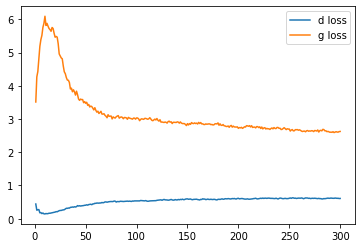

In [46]:
# Display losses for both the generator and discriminator
plt.figure()
plt.plot(range(1, num_epochs + 1), d_losses, label = 'd loss')
plt.plot(range(1, num_epochs + 1), g_losses, label = 'g loss')    
plt.legend()
plt.show()

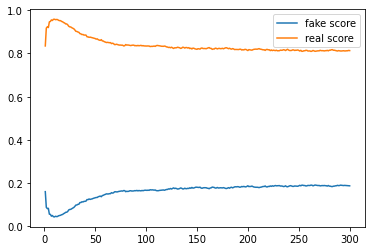

In [47]:
# Display accuracy scores for both the generator and discriminator
plt.figure()
plt.plot(range(1, num_epochs + 1), fake_scores, label='fake score')
plt.plot(range(1, num_epochs + 1), real_scores, label='real score')    
plt.legend()
plt.show()

In [57]:
# Generate a few fake samples (5 of them) for visualization
n_samples = 5
z = torch.randn(n_samples, latent_size).cuda()
z = Variable(z)
fake_images = G(z)
fake_images = fake_images.cpu().detach().numpy().reshape(n_samples, 28, 28)
print(fake_images.shape)

(5, 28, 28)


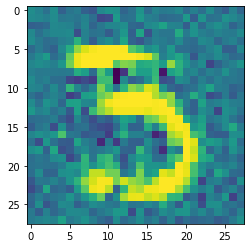

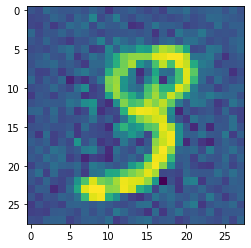

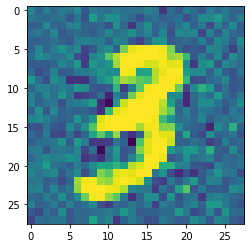

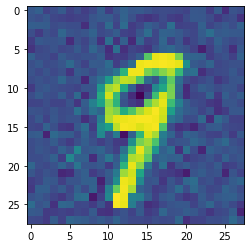

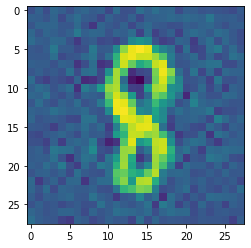

In [60]:
# Display
plt.figure()
plt.imshow(fake_images[0])
plt.show()
plt.figure()
plt.imshow(fake_images[1])
plt.show()
plt.figure()
plt.imshow(fake_images[2])
plt.show()
plt.figure()
plt.imshow(fake_images[3])
plt.show()
plt.figure()
plt.imshow(fake_images[4])
plt.show()